colab에서 학습한 ssd 모델을 이용해서 local에서 hand sign letter들을 추론
- Tensorflow 설치
- Tensorflow Object Detectoin API2 설치
    - 환경변수(PYTHONPATH) 설정
- pyyaml 라이브러리 설치
    - pip install pyyaml
- 학습된 모델
    - checkpoint 파일
    - labelmap 설정 파일
    - pipeline.config 설정파일

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

# 경로를 변수로 정의

In [3]:
PIPELINE_CONFIG_PATH = 'workspace/model/pipeline.config'
LABELMAP_PATH = 'workspace/labelmap/label_map.pbtxt'
CHECKPOINT_DIR_PATH = 'workspace/model/checkpoint_backup/checkpoint'

# 모델 생성(restore)

In [6]:
config = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG_PATH)   # pipeline config 파일 읽어오기
detection_model = model_builder.build(model_config=config['model'], is_training=False) # pipeline config 설정에 맞춰 모델을 생성 
# 모델에 학습된 checkpoint(weight저장)를 주입
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_DIR_PATH, 'ckpt-51')).expect_partial()

# detection 함수
- tf.Tensor를 입력 이미지로 받는다.
- data 정처리 -> 추론 -> 후처리

In [10]:
def detect_function(img):
    img, shapes = detection_model.preprocess(img)  # resize, normalize -> (전처리된img, img shape)
    pred = detection_model.predict(img, shapes)   # 모든 bbox를 추론
    result = detection_model.postprocess(pred, shapes)   # confidence score 높은 100개의 bbox만 추출
    
    return result

# label map 로딩

In [28]:
category_index = label_map_util.create_category_index_from_labelmap(LABELMAP_PATH)  # label map을 dict형태로 반환

In [29]:
type(category_index)

dict

# 이미지 디텍션

In [41]:
test_img = 'test_data/test/A22_jpg.rf.f02ad8558ce1c88213b4f83c0bc66bc8.jpg'  # A
# test_img = 'test_data/test/Z16_jpg.rf.309328aaeb31736f8a93a570d6d4f140.jpg'   # Z
# 이미지 읽고 batch축 늘리고 tf.Tensor로 변환
img_np_org = cv2.cvtColor(cv2.imread(test_img), cv2.COLOR_BGR2RGB)
img_np = img_np_org[np.newaxis, ...]
input_tensor = tf.convert_to_tensor(img_np, dtype=np.float32)   # ndarray -> tf.Tensor / dtype: uint8 -> float32

# 추론
result = detect_function(input_tensor)

In [42]:
# 추론 결과들이 tf.Tensor 타입 -> ndarray로 변환(visualization_utils() 사용 위해)
num_detections = int(result.pop('num_detections'))
num_detections

100

In [43]:
detection_dict = {key:value[0, :num_detections].numpy() for key, value in result.items()}
detection_dict['num_detections'] = num_detections

In [44]:
# 추론한 label을 float32에서 int로 변환
detection_dict['detection_classes'] = detection_dict['detection_classes'].astype(np.int64)

In [45]:
type(detection_dict)

dict

In [46]:
# 출력 이미지를 생성 - visualization_utils() 사용
img_np_copy = img_np_org.copy()
img = viz_utils.visualize_boxes_and_labels_on_image_array(
    img_np_copy,   # bbox 그릴 이미지
    detection_dict['detection_boxes'],   # bbox 좌표
    detection_dict['detection_classes'] + 1,   # bbox 내부 object label (추론한 label과 labelmap의 id 맞추기 위해 +1)
    detection_dict['detection_scores'],   # bbox confidence score
    category_index,   # label map dictionary
    use_normalized_coordinates=True,   # 추론한 bbox 좌표가 정규화됐는지 여부
    max_boxes_to_draw=10,   # 최대 몇 개의 bbox를 그릴지 지정(기본 20개)
    min_score_thresh=0.6
    )

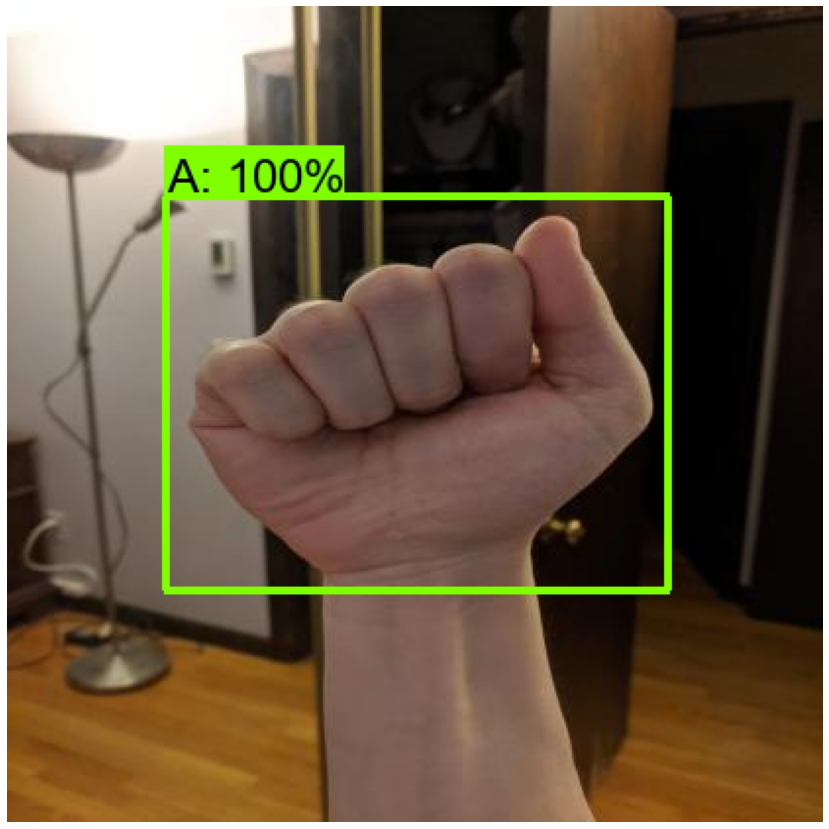

In [48]:
%matplotlib inline

save_file_path = 'test_a1.jpg'
plt.figure(figsize=(15,15))
plt.imshow(img)
plt.axis('off')
plt.savefig(save_file_path)
plt.show()

# 실시간 웹캠 디텍션 + 동영상

In [52]:
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()   # 한 프레임 읽어오기
    if not ret:
        print('캡쳐 실패')
        break
    frame = cv2.flip(frame, 1)
    ###########################################
    # detection + bbox 시각화
    ###########################################
    img_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_tensor = tf.convert_to_tensor(img_np[np.newaxis, ...], dtype=tf.float32)
    result = detection_model(input_tensor)
    num_detections = int(result.pop('num_detections'))
    detection_dict = {key:value[0, :num_detections].numpy() for key, value in result.items()}
    detection_dict['num_detections'] = num_detections
    detection_dict['detection_classes'] = detection_dict['detection_classes'].astype(np.int64)
    
    img = viz_utils.visualize_boxes_and_labels_on_image_array(
        frame,
        detection_dict['detection_boxes'],
        detection_dict['detection_classes']+1,
        detection_dict['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=10,
        min_score_thresh=0.6
    )
    
    # 출력
    cv2.imshow('frame', img)
    if cv2.waitKey(1) == 27:  # esc
        break
        
cap.release()
cv2.destroyAllWindows()